## Dropout for Regression

In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
%matplotlib inline
torch.manual_seed(0)

In [2]:
class Data(Dataset):
    def __init__(self, n_samples=40, noise_std=0.5, train=True):
        self.x = torch.linspace(-1, 1, n_samples).view(-1, 1)
        self.f = self.x ** 2
        if train: # Uses different torch seed
            self.y = self.f + noise_std * torch.randn(self.f.shape)
            self.y = self.y.view(-1, 1)
        else:
            torch.manual_seed(1)
            self.y = self.f + noise_std * torch.randn(self.f.shape)
            self.y = self.y.view(-1, 1)
            torch.manual_seed(0)
        self.len = self.x.shape
        
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return self.len
    
    def plot_data(self):
        plt.figure(figsize=(6.1, 10))
        plt.scatter(self.x.numpy(), self.y.numpy(), label='Samples')
        plt.plot(self.x.numpy(), self.f.numpy(), label='True function', color='orange')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.xlim((-1, 1))
        plt.ylim((-2, 2.5))
        plt.legend()
        plt.show()

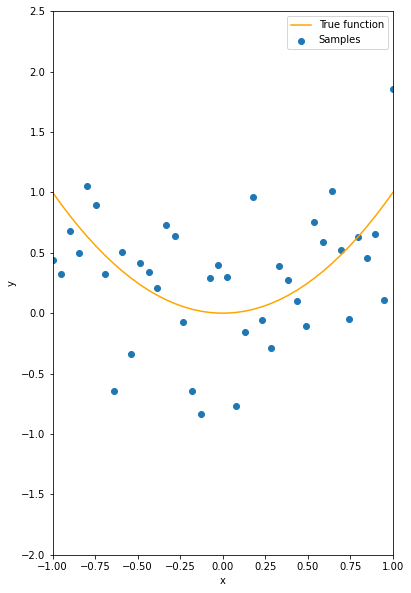

In [3]:
train_data = Data()
train_data.plot_data()

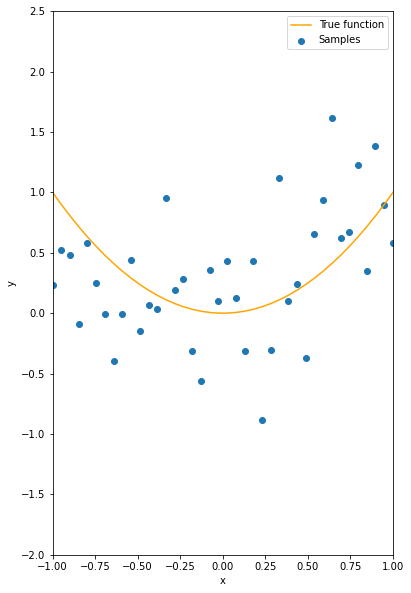

In [4]:
val_data = Data(train=False)
val_data.plot_data()

In [5]:
class Net(nn.Module):
    def __init__(self, dim_in, dim_H, dim_out, drop_p=0, act_func=F.relu):
        super(Net, self).__init__()
        self.act_func = act_func
        self.drop = nn.Dropout(drop_p)
        self.Lin1 = nn.Linear(dim_in, dim_H)
        self.Lin2 = nn.Linear(dim_H, dim_H)
        self.Lin3 = nn.Linear(dim_H, dim_out)
        
    def forward(self, x):
        x = self.drop(self.Lin1(x))
        x = self.act_func(x)
        x = self.drop(self.Lin2(x))
        x = self.act_func(x)
        x = self.drop(self.Lin3(x))
        return x

In [6]:
model = Net(1, 300, 1)
model_drop = Net(1, 300, 1, 0.3)

In [7]:
model_drop.train()
opt = optim.Adam(model.parameters(), lr=0.01)
opt_drop = optim.Adam(model_drop.parameters(), lr=0.01)
criterion = nn.MSELoss()

In [8]:
Loss = {'train drop': [], 'train no drop': [], 'val drop': [], 'val no drop': []}

In [9]:
def train_models(epochs):
    for epoch in range(epochs):
        model_drop.train()
        y_hat = model(train_data.x)
        y_hat_drop = model_drop(train_data.x)
        loss = criterion(y_hat, train_data.y)
        loss_drop = criterion(y_hat_drop, train_data.y)
        loss.backward()
        loss_drop.backward()
        opt.step()
        opt_drop.step()
        opt.zero_grad()
        opt_drop.zero_grad()
        
        model_drop.eval()
        y_pred = model(val_data.x)
        y_pred_drop = model_drop(val_data.x)
        val_loss = criterion(y_pred, val_data.y)
        val_loss_drop = criterion(y_pred_drop, val_data.y)
        
        Loss['train drop'].append(loss_drop.item())
        Loss['train no drop'].append(loss.item())
        Loss['val drop'].append(val_loss_drop.item())
        Loss['val no drop'].append(val_loss.item())
        if epoch % 50 == 0:
            print(epoch)

In [10]:
train_models(500)

0
50
100
150
200
250
300
350
400
450


In [11]:
y_hat = model(train_data.x)
y_hat_drop = model_drop(train_data.x)

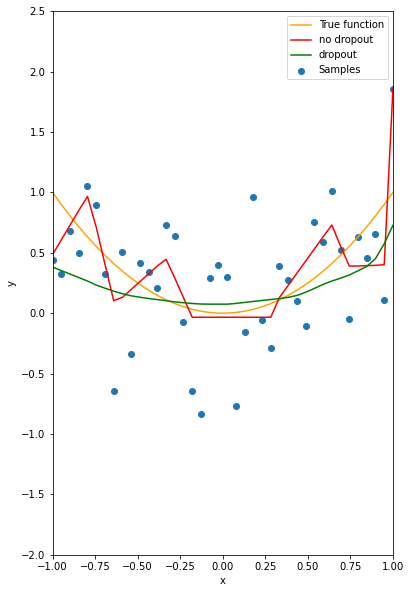

In [12]:
plt.figure(figsize=(6.1, 10))
plt.scatter(train_data.x.numpy(), train_data.y.numpy(), label='Samples')
plt.plot(train_data.x.numpy(), train_data.f.numpy(), label='True function', color='orange')
plt.plot(train_data.x.numpy(), y_hat.detach().numpy(), label='no dropout', c='r')
plt.plot(train_data.x.numpy(), y_hat_drop.detach().numpy(), label='dropout', c ='g')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim((-1, 1))
plt.ylim((-2, 2.5))
plt.legend()
plt.show()

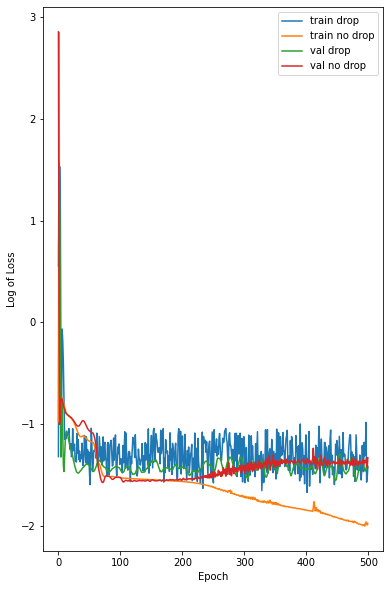

In [13]:
plt.figure(figsize=(6.1, 10))
for key, value in Loss.items():
    plt.plot(np.log(np.array(value)), label=key)
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Log of Loss")
plt.show()